In [53]:

import numpy as np
import pandas as pd
import plotly.express as px
import json
import sys
from glob import glob
from pathlib import Path
from tqdm import tqdm

import random
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import MaxAbsScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score
import plotly.express as px
from enum import Enum
from tqdm.notebook import tqdm
import multiprocessing as mp


In [54]:
class InstanceType(Enum):
    ALL = 1
    OPTIMIZATION = 2
    SAT = 3

data_types_to_consider = InstanceType.OPTIMIZATION

def string_to_instance_type(s):
    return InstanceType.SAT if s == 'SAT' else InstanceType.OPTIMIZATION


In [55]:
def plot_dataframe_column(df, column_name):
    """
    Plots a single column of a DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame
        column_name (str): The name of the column to plot
    """
    if column_name in df.columns:
        df[column_name].plot()
        plt.title(f'Plot of column "{column_name}"')
        plt.xlabel('Index')
        plt.ylabel(column_name)
        plt.show()
    else:
        print(f'Error: Column "{column_name}" not found in the DataFrame.')


In [97]:
base = "data/done-soon/temp/problem_output/"
all_normal_files = glob("data/problem_output/*NORMAL.json")
df = pd.DataFrame()
data = []

# find index of statistics array at certain percent of TL
def find_index_at_percent(stats, wall_clock_time_to_find):
    left = 0
    right = len(stats) - 1
    while left <= right:
        mid = (left + right) // 2
        
        if stats[mid] is not None:

            if abs(left - right) <= 1:
                left_time_at_convergence = stats[left]['search_time']
                right_time_at_convergence = stats[right]['search_time']

                left_difference = abs(wall_clock_time_to_find - left_time_at_convergence)
                right_difference = abs(wall_clock_time_to_find - right_time_at_convergence)
                
                if left_difference < right_difference:
                    value = left_time_at_convergence
                    difference = left_difference
                    index_to_return = left
                else:
                    value = right_time_at_convergence
                    difference = right_difference
                    index_to_return = right
                
                if difference > 72:
                    return -1
                return index_to_return
                
            elif stats[mid]['search_time'] < wall_clock_time_to_find:
                left = mid
            else:
                right = mid
        else:
            print("none?", mid)
            return -1

    print("never converges?")
    return -1


num_without_search_time = 0
for i, normal in tqdm(enumerate(all_normal_files)):
    mzn = normal[normal.find("MZN-")+4:normal.find("-DZN")] + ".mzn"
    dzn = normal[normal.find("DZN-")+4:normal.find("-OUTPUT")] + ".dzn"

    stats = Path(f"{normal[:-12]}-STATS.json")
    if stats.exists():
        with open(normal, 'r') as normal_output, open(f"{normal[:-12]}-STATS.json", 'r') as stats_output:
            line = normal_output.readline()
            if line: # don't read json from empty output
                
                normal_time = json.loads(line).get('time') # wall time
                stats_all_lines = [json.loads(line).get('statistics') for line in stats_output.readlines()]
                final_statistic = stats_all_lines[-1]

                # plot_dataframe_column(pd.DataFrame(stats_all_lines), 'search_time')
                
                if normal_time and final_statistic:
                    if "search_time" not in final_statistic.keys():
                            num_without_search_time += 1
                    else:
                            normal_time *= 0.001 # Convert from milliseconds to seconds

                            if normal_time <= 10:
                                continue

                            # To avoid loading in too much data into memory, only load the ones at certain percentages
                            # specifically, every half percent intervals
                            statistics_per_half_percent = {}
                            for percent in range(1, 200):
                                

                                # normal_time is in seconds, so this is percentage of two hours
                                wall_clock_time_at_percent = (60 * 60 * 2) * percent/100 / 2

                                if wall_clock_time_at_percent >= final_statistic['search_time']: # no more data :(
                                    break 

                                # print("searching for" , wall_clock_time_at_percent)

                                index_for_percent = find_index_at_percent(stats_all_lines, wall_clock_time_at_percent)
                                # print(index_for_percent)

                                if index_for_percent == -1:
                                    statistics_per_half_percent[percent] = None

                                # print(stats_all_lines[index_for_percent]['search_time'])

                                statistics_per_half_percent[percent] = stats_all_lines[index_for_percent]
                            



                            data.append({
                                'normal_time': normal_time,
                                'stat_time': final_statistic['search_time'],
                                'problem': normal,
                                'statistics': statistics_per_half_percent,
                                'mzn': mzn,
                                'dzn': dzn
                            })
                

df = pd.DataFrame(data)
all_data = df
all_data.shape

0it [00:00, ?it/s]

none? 23309
none? 12263
none? 9838
none? 10129
none? 6264
none? 4772
none? 5509
none? 3659
none? 3672
none? 4101
none? 4196
none? 850
none? 853
none? 853
none? 853
none? 853
none? 853
none? 853
none? 853
none? 856
none? 856
none? 856
none? 880
none? 1055
none? 1443
none? 1443
none? 1460
none? 1696
none? 1910
none? 1913
none? 1931
none? 1937
none? 1972
none? 1978
none? 1978


(1132, 6)

In [57]:
df

,normal_time,stat_time,problem,statistics,mzn,dzn
0,7200.882,7199.268198,data/problem_output/PROB-city-position-MZN-cit...,"{0: {'conflicts': 388180, 'ewma_conflicts': 38...",city-position.mzn,city-7-04.dzn
1,7210.505,7121.926723,data/problem_output/PROB-2DBinPacking-MZN-2DPa...,"{3: {'conflicts': 631792, 'ewma_conflicts': 63...",2DPacking.mzn,Class5_80_8.dzn
2,71.478,213.285878,data/problem_output/PROB-amaze-MZN-amaze2-DZN-...,"{20: {'conflicts': 221581, 'ewma_conflicts': 2...",amaze2.mzn,2012-07-05.dzn
3,7201.437,3512.053385,data/problem_output/PROB-ship-schedule-MZN-shi...,"{22: {'conflicts': 865942, 'ewma_conflicts': 8...",ship-schedule.mip.mzn,8ShipsUnconst.dzn
4,7201.694,7199.867735,data/problem_output/PROB-miplib-MZN-ns4-pr6-DZ...,"{33: {'conflicts': 1135475, 'ewma_conflicts': ...",ns4-pr6.mzn,NO-MODEL-FILE.dzn
...,...,...,...,...,...,...
1127,10.501,42.884265,data/problem_output/PROB-wwtpp-real-MZN-wwtpp-...,"{16698: {'conflicts': 21344, 'ewma_conflicts':...",wwtpp.mzn,ex02400_2400_100.dzn
1128,18.754,229.142342,data/problem_output/PROB-rcpsp-wet-MZN-rcpsp-w...,"{16722: {'conflicts': 329317, 'ewma_conflicts'...",rcpsp-wet.mzn,j30_1_3-wet.dzn
1129,11.433,45.670814,data/problem_output/PROB-2DBinPacking-MZN-2DPa...,"{16727: {'conflicts': 67862, 'ewma_conflicts':...",2DPacking.mzn,Class4_40_7.dzn
1130,16.353,77.763970,data/problem_output/PROB-mrcpsp-MZN-mrcpsp-DZN...,"{16765: {'conflicts': 195622, 'ewma_conflicts'...",mrcpsp.mzn,j30_46_4.dzn


In [190]:
def cleanup(df):
    if "decision_level_sat" in df:
        del df["decision_level_sat"]
    if "ewma_decision_level_mip" in df:
        del df["ewma_decision_level_mip"]
    if "decision_level_mip" in df:
        del df["decision_level_mip"]

    # Added
    del df["best_objective"]
    del df["ewma_best_objective"] 
    
#     df["unassnVar"]   = (2**df['vars']) - df['opennodes']
#     df["fracFailUnassn"]     = df['conflicts'] / df['unassnVar']         # num failures/ num open nodes
    df["fracOpenVisit"]  = (df['vars'] - df['opennodes']) / (df['opennodes'] + sys.float_info.epsilon)       # ratio of open nodes to visited nodes (how much of soln space explored)
    df["fracBoolVars"]     = df['boolVars'] / (df['vars'] + sys.float_info.epsilon)                 # num bools / total num of vars
    df["fracPropVars"]     = df['propagations'] / (df['vars'] + sys.float_info.epsilon)        # num propagations/ total num of vars
#     df["frac_unassigned"] = df['unassnVar'] / df['vars']  # current assignments/ total vars
    df["fracLongClauses"] = df['long'] + df['bin'] + df['tern']         # fraction of learnt clauses that have more than 3 literals
    df["freqBackjumps"]  = df['back_jumps']/ (df['search_time'] + sys.float_info.epsilon)

    return df


def gradients(df_prev, df_curr):
    keys=['conflicts','ewma_conflicts','decisions','search_iterations','opennodes','ewma_opennodes',
          'vars','back_jumps','ewma_back_jumps','solutions','total_time','intVars', 'search_time',
          'propagations','sat_propagations','ewma_propagations','propagators','boolVars','learnt',
          'bin','tern','long','peak_depth','decision_level_engine','ewma_decision_level_engine',
          'decision_level_treesize','clause_mem','prop_mem',
          'fracOpenVisit','fracBoolVars','fracPropVars','freqBackjumps']
    for i in keys:
        df_curr[i+'_gradient']=(df_curr[i]-df_prev[i])/0.05*7200
    return df_curr

In [191]:
all_data_filtered = all_data[all_data['normal_time'] > 10]
all_data_filtered.shape




(1132, 6)

In [192]:
features_at_percent = {}

for i in tqdm(range(1,200)):
    df_percent=[]
    for id, problem in all_data_filtered.iterrows():
        
        if i in problem.statistics:
            p = problem.statistics[i]
            
            # Apparently there are four instances that do not have all keys. No clue what happened there.
            if len(p.keys()) != 33:
                continue
            
            new_p = dict(p)
            new_p=cleanup(new_p)

            new_p['mzn'] = problem['mzn']
            new_p['dzn'] = problem['dzn']
            new_p['solved_within_time_limit'] = problem['normal_time'] < 7199

            if i!=1:     
                if  (i-1) in features_at_percent and id in features_at_percent[i-1].index:
                    new_p=gradients(features_at_percent[i-1].loc[id], new_p)
                    new_p['has_gradients'] = True
                else:
                    new_p['has_gradients'] = False
            df_percent.append((id, new_p))        
            
    
    df_i = pd.DataFrame([a[1] for a in df_percent], index=[a[0] for a in df_percent])
    # df_i=df_i.fillna(value = 0)
    features_at_percent[i]=df_i
    df_prev=df_i



  0%|          | 0/199 [00:00<?, ?it/s]

In [193]:
for i in range(2, 200):
    features_at_percent[i] = features_at_percent[i][features_at_percent[i]['has_gradients'] == True]

In [194]:
features_at_percent[5].columns[features_at_percent[5].isna().any()].tolist()

[]

## Train test split

In [195]:
def preprocessing(df):
    df1=df.drop(['mzn','dzn'], axis=1)
    df1.drop(df1.columns[df1.nunique() == 1], axis=1, inplace=True) #drop cols with constant value
    #rescale data
    transformer = MaxAbsScaler().fit(df1)
    df1 = pd.DataFrame(transformer.transform(df1), columns=df1.columns, index=df1.index) #normalise data
    return df1

In [196]:
def create_split(df, test_size=0.25, random_state=22):
    return train_test_split(df.drop(columns = ["solved_within_time_limit"]),\
                                df["solved_within_time_limit"], test_size=test_size, random_state=random_state, stratify=df["solved_within_time_limit"])


In [197]:
df=features_at_percent[5] #THE NUMBER HERE IS THE % OF TL
df=preprocessing(df)
# training-testing split
X_train, X_test, y_train, y_test  = train_test_split(df.drop(columns = ["solved_within_time_limit"]),\
                                                     df["solved_within_time_limit"], test_size=0.25)



In [198]:
X_train.keys()

Index(['conflicts', 'ewma_conflicts', 'decisions', 'search_iterations',
       'opennodes', 'ewma_opennodes', 'vars', 'back_jumps', 'ewma_back_jumps',
       'solutions', 'total_time', 'search_time', 'intVars', 'propagations',
       'sat_propagations', 'ewma_propagations', 'propagators', 'boolVars',
       'learnt', 'bin', 'tern', 'long', 'peak_depth', 'decision_level_engine',
       'ewma_decision_level_engine', 'decision_level_treesize', 'clause_mem',
       'prop_mem', 'fracOpenVisit', 'fracBoolVars', 'fracPropVars',
       'fracLongClauses', 'freqBackjumps', 'conflicts_gradient',
       'ewma_conflicts_gradient', 'decisions_gradient',
       'search_iterations_gradient', 'opennodes_gradient',
       'ewma_opennodes_gradient', 'vars_gradient', 'back_jumps_gradient',
       'ewma_back_jumps_gradient', 'solutions_gradient', 'total_time_gradient',
       'search_time_gradient', 'propagations_gradient',
       'sat_propagations_gradient', 'ewma_propagations_gradient',
       'boolVars_

In [199]:
y_train.value_counts()

0.0    364
1.0    245
Name: solved_within_time_limit, dtype: int64

In [200]:
y_test.value_counts()

0.0    127
1.0     77
Name: solved_within_time_limit, dtype: int64

In [201]:
models = {}

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models['LR'] = LogisticRegression(max_iter=1000, C=1000 , class_weight = 'balanced',random_state=22)

#Support Vector Machine
from sklearn.svm import SVC
models['SVM'] = SVC(kernel = 'rbf', class_weight = 'balanced', probability = True, random_state=22)

# Random Forest
from sklearn.ensemble import RandomForestClassifier
models['RF'] = RandomForestClassifier(min_samples_leaf = 5, class_weight = 'balanced_subsample',random_state=22)

#Extra Tree
from sklearn.ensemble import ExtraTreesClassifier
models['ET'] = ExtraTreesClassifier(class_weight = 'balanced', random_state=22)

#Multi-layered perceptron
from sklearn.neural_network import MLPClassifier
models['MLP'] = MLPClassifier(random_state=22)

# Naive Bayes
#from sklearn.naive_bayes import GaussianNB
#models['NB'] = GaussianNB()

# Adaboost
from sklearn.ensemble import AdaBoostClassifier
models['AB'] = AdaBoostClassifier()

#KNN
#from sklearn.neighbors import KNeighborsClassifier
#models['KNN'] = KNeighborsClassifier(weights = 'distance')

# Decision Trees
from sklearn.tree import DecisionTreeClassifier
models['DT'] = DecisionTreeClassifier(max_depth = 5, class_weight = 'balanced', random_state=22)

#Dummy classifier
from sklearn.dummy import DummyClassifier
models['DUM'] = DummyClassifier(strategy="stratified")

In [202]:
rf_reg = RandomForestClassifier(min_samples_leaf = 1)
rf_reg.fit(X_train,y_train)

predictions = rf_reg.predict(X_test)
importances = rf_reg.feature_importances_

print('The F1 score with all features of a RandomForestClassifier with min_samples_leaf of 5 is ', f1_score(y_test, predictions))

The F1 score with all features of a RandomForestClassifier with min_samples_leaf of 5 is  0.8053691275167787


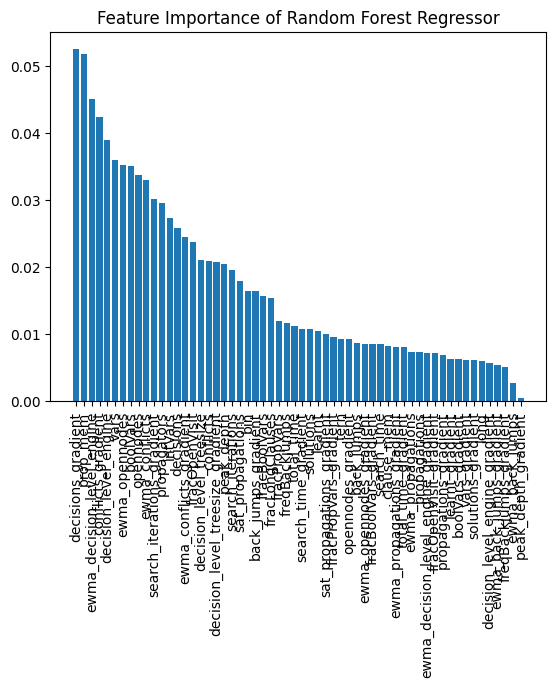

In [203]:


sorted_importance_indices = np.argsort(importances)[::-1]

plt.title('Feature Importance of Random Forest Regressor')
plt.bar(range(len(sorted_importance_indices)), importances[sorted_importance_indices], align='center')
plt.xticks(range(len(sorted_importance_indices)), X_train.columns[sorted_importance_indices], rotation=90)
plt.rcParams["figure.figsize"] = (20,3)
plt.show()



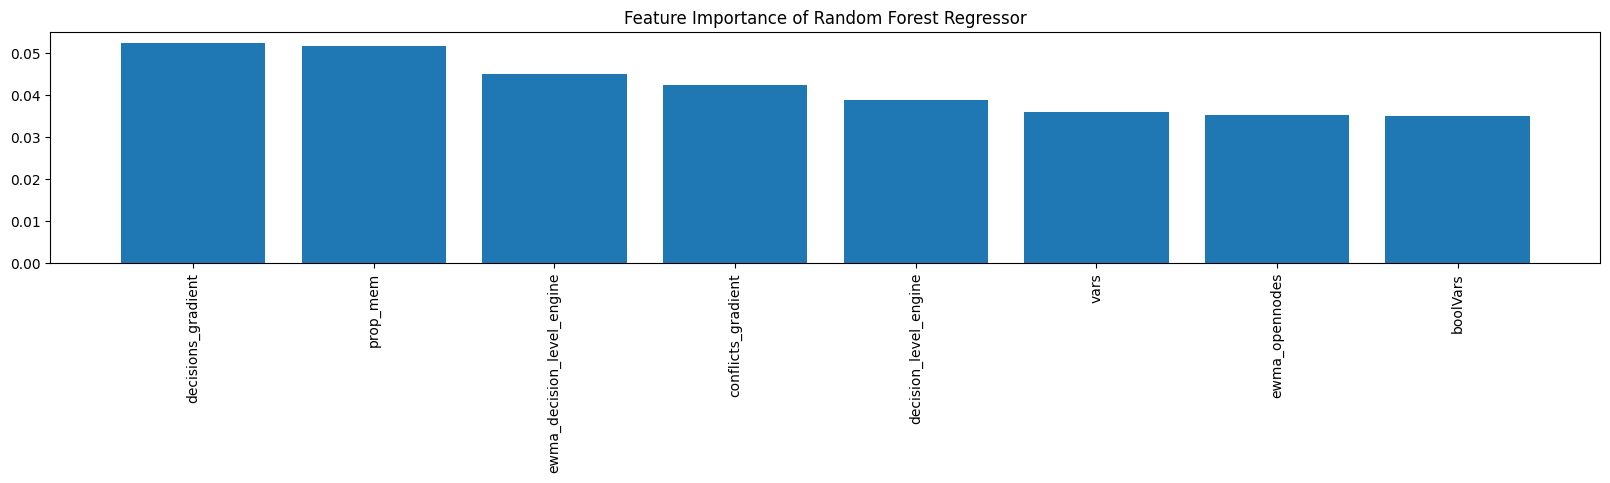

In [204]:
sorted_importance_indices = np.argsort(importances)[::-1][:8]

plt.title('Feature Importance of Random Forest Regressor')
plt.bar(range(8), importances[sorted_importance_indices], align='center')
plt.xticks(range(8), X_train.columns[sorted_importance_indices], rotation=90)
plt.rcParams["figure.figsize"] = (20,3)
plt.show()


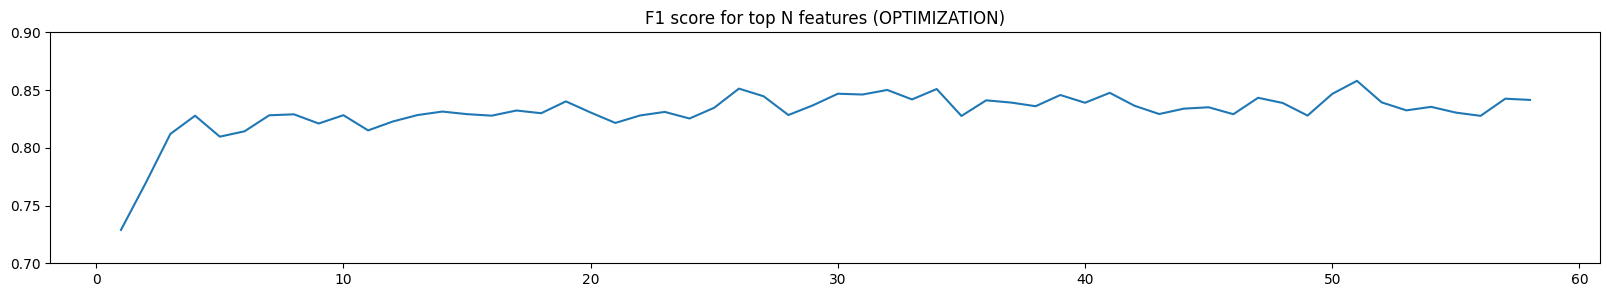

[(58, 0.841430655774613), (57, 0.8425061796833602), (56, 0.8276498079615437), (55, 0.8304525309784692), (54, 0.83543625856287), (53, 0.8323946843155852), (52, 0.8392931951540449), (51, 0.8579607904229649), (50, 0.8466552418535397), (49, 0.8278795931989567), (48, 0.8387568090529196), (47, 0.8432978912628035), (46, 0.82907076775319), (45, 0.8350715204747237), (44, 0.8338783163802139), (43, 0.8292164471736461), (42, 0.8363909197041988), (41, 0.8475802581842717), (40, 0.8389947057727142), (39, 0.8456811544885594), (38, 0.8359919607898592), (37, 0.8391659917134374), (36, 0.8410683801035745), (35, 0.8275577690018772), (34, 0.8508723490027954), (33, 0.8418591230575752), (32, 0.8500678135353585), (31, 0.8461115129141005), (30, 0.8467955355906573), (29, 0.836830169861309), (28, 0.8283495107432743), (27, 0.8445787351611862), (26, 0.8512165106088252), (25, 0.8346700598737842), (24, 0.8253341065037804), (23, 0.8310526186714438), (22, 0.827976651973317), (21, 0.8215116912256013), (20, 0.83054614116

In [205]:
sorted_importance_indices = np.argsort(importances)[::-1]

def f1_with_n_top_features(n, importance_column_indices):
    summed = 0
    for i in range(0, 10):
        X_train, X_test, y_train, y_test  = train_test_split(df.drop(columns = ["solved_within_time_limit"]),\
                                                     df["solved_within_time_limit"], test_size=0.25, stratify=df["solved_within_time_limit"])
        rf_reg = RandomForestClassifier(min_samples_leaf = 5)
        rf_reg.fit(X_train.iloc[:, importance_column_indices[:n]], y_train)

        predictions = rf_reg.predict(X_test.iloc[:, importance_column_indices[:n]])
        summed += f1_score(y_test, predictions)
    return summed / 10



f1_scores = [(i, f1_with_n_top_features(i, sorted_importance_indices)) for i in range(1, len(sorted_importance_indices) + 1)[::-1]]

plt.title(f'F1 score for top N features ({"OPTIMIZATION" if data_types_to_consider is InstanceType.OPTIMIZATION else "SAT"})')
plt.plot([a[0] for a in f1_scores], [a[1] for a in f1_scores])
plt.gca().set_ylim([0.7,0.9])
plt.rcParams["figure.figsize"] = (20,3)
plt.show()

print(f1_scores)

In [206]:

summed = 0
for i in range(0, 10):
    X_train, X_test, y_train, y_test  = train_test_split(df.drop(columns = ["solved_within_time_limit"]),\
                                                    df["solved_within_time_limit"], test_size=0.25)
    rf_reg = RandomForestClassifier(min_samples_leaf = 5)
    rf_reg.fit(X_train.iloc[:, sorted_importance_indices[4:len(sorted_importance_indices)]], y_train)

    predictions = rf_reg.predict(X_test.iloc[:, sorted_importance_indices[4:len(sorted_importance_indices)]])
    summed += f1_score(y_test, predictions)

print(summed)

8.37956254043404


In [207]:
def results_plt(X_train, y_train, X_test, y_test, perc_TL):
    train_accuracy, accuracy, precision, recall, auc, f1 = {}, {}, {}, {}, {}, {}
    figs, axs = plt.subplots(2,3,figsize=(20, 12))

    for i, key in enumerate(models.keys()):

        # Fit the classifier model
        models[key].fit(X_train, y_train)

        predictions = models[key].predict(X_test)
        predictions_prob = models[key].predict_proba(X_test)[:,1]
        train_predictions = models[key].predict(X_train)
        # Predic  
        # Calculate Accuracy, Precision and Recall Metrics
        accuracy[key] = accuracy_score(predictions, y_test)
        precision[key] = precision_score(predictions, y_test, zero_division=1)
        recall[key] = recall_score(predictions, y_test, zero_division=1)
        auc[key] = roc_auc_score(y_test, predictions_prob)
        train_accuracy[key] = accuracy_score(train_predictions, y_train)
        f1[key] = f1_score(y_test,predictions)
        #should it be (true, pred)? yes

        #To Display
        RocCurveDisplay.from_predictions(y_test, predictions_prob, name=key , ax=axs[0,0])
        axs[0,1].bar(key, accuracy[key]) 
        axs[0,2].bar(key, train_accuracy[key]) 
        axs[1,0].bar(key, recall[key])
        axs[1,1].bar(key, precision[key])
        axs[1,2].bar(key, f1[key])

        axs[0,0].set_title("ROC Curve for "+perc_TL+"% TL")
#         axs[0].set_ylabel("Accuracy")

        axs[0,1].set_title("Test Accuracy for "+perc_TL+"% TL")
        axs[0,1].set_ylabel("Accuracy")
        axs[0,1].grid(axis='y', color='gray', linestyle='dashed')

        axs[0,2].set_title("Train Accuracy for "+perc_TL+"% TL")
        axs[0,2].set_ylabel("Accuracy")
        axs[0,2].grid(axis='y', color='gray', linestyle='dashed')

        axs[1,0].set_title("Recall for "+perc_TL+"% TL")
        axs[1,0].set_ylabel("Recall")
        axs[1,0].grid(axis='y', color='gray', linestyle='dashed')


        axs[1,1].set_title("Precision "+perc_TL+"% TL")
        axs[1,1].set_ylabel("F1")
        axs[1,1].grid(axis='y', color='gray', linestyle='dashed')

        axs[1,2].set_title("F1 "+perc_TL+"% TL")
        axs[1,2].set_ylabel("F1")
        axs[1,2].grid(axis='y', color='gray', linestyle='dashed')
        
        
        [axs[y, x].tick_params(axis='x', labelrotation=60) for y in range(len(axs)) for x in range(len(axs[y]))]

/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


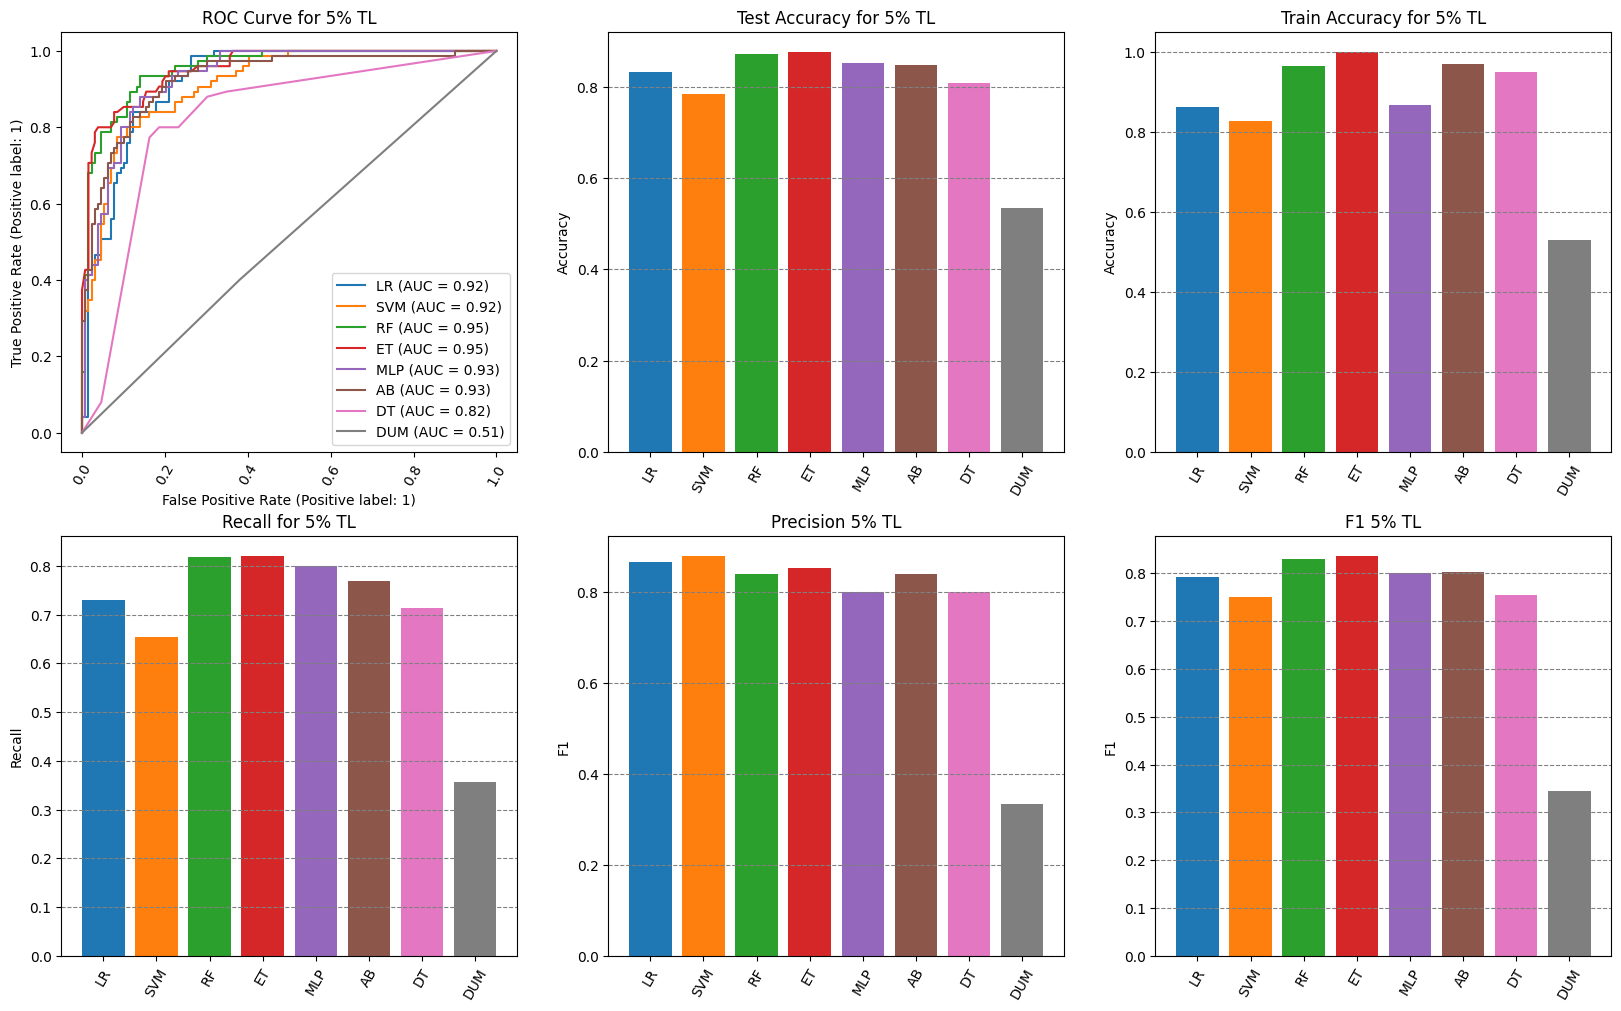

In [208]:


results_plt(X_train, y_train, X_test, y_test, "5")



       0    1
0    492  582
1    492  457
2    492  398
3    491  358
4    491  322
..   ...  ...
194  359    2
195  351    2
196  345    2
197  333    2
198  316    2

[199 rows x 2 columns]


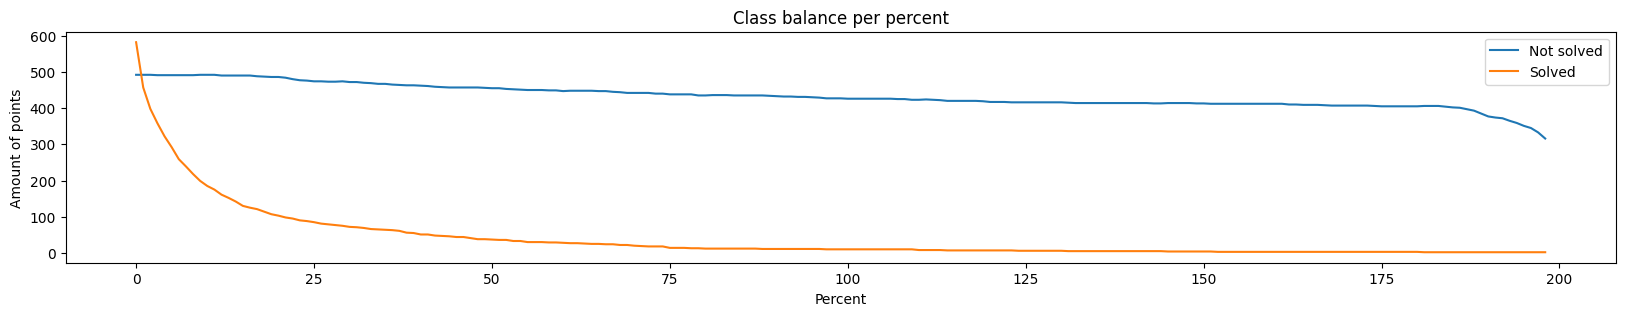

In [209]:
def label_split_at_percent(features_at_percent, percent):
    
    df_at_percent = features_at_percent[percent]
    if df_at_percent.empty:
        return (0, 0)
    df_at_percent = preprocessing(df_at_percent)
    if df_at_percent.empty:
        return (0, 0)
    
    vc = df_at_percent["solved_within_time_limit"].value_counts()
    return vc[0], vc[1]

value_counts_df = pd.DataFrame([label_split_at_percent(features_at_percent, i) for i in range(1, 200)])
print(value_counts_df)

# Plot the lines
plt.figure()
value_counts_df[0].plot(label='Not solved')
value_counts_df[1].plot(label='Solved')

# Customize the plot
plt.title('Class balance per percent')
plt.xlabel('Percent')
plt.ylabel('Amount of points')
plt.legend()
plt.show()




In [210]:


def get_f1_scores(args):
    features_at_percent, percent, rep = args
    df_at_percent = features_at_percent[percent]
    if df_at_percent.empty:
        return (0, 0)
    df_at_percent = preprocessing(df_at_percent)
    if df_at_percent.empty:
        return (0, 0)

    X_train, X_test, y_train, y_test  = create_split(df_at_percent, random_state=percent + (100 * rep))
    model = RandomForestClassifier(min_samples_leaf = 5, class_weight = 'balanced_subsample',random_state=percent + (100 * rep))
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    return (f1_score(y_test, predictions), len(df_at_percent))

def get_f1_over_time_for_model(features_at_percent, repetitions=10):
    f1_scores_mean = []
    f1_scores_std = []
    lengths = []
    for percent in tqdm(range(1, 200), desc="Percent"):
        with mp.Pool(mp.cpu_count()) as pool:
            f1_scores_and_lengths = list(pool.imap(get_f1_scores,
                                            [(features_at_percent, percent, rep) for rep in range(repetitions)]))
            length_to_add = [f[1] for f in f1_scores_and_lengths][0]
            f1_scores = [f[0] for f in f1_scores_and_lengths]
            f1_scores_mean.append(np.mean(f1_scores))
            f1_scores_std.append(np.std(f1_scores))
            lengths.append(length_to_add)

    return f1_scores_mean, f1_scores_std, lengths
    

In [211]:
f1_scores_mean, f1_scores_std, lengths = get_f1_over_time_for_model(features_at_percent)

Percent:   0%|          | 0/199 [00:00<?, ?it/s]

/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/alexander/Documents/TUDelft/done-soon/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

In [212]:
pd.DataFrame([get_f1_scores((features_at_percent, 80, rep)) for rep in range(10)])[0].mean()

0.13

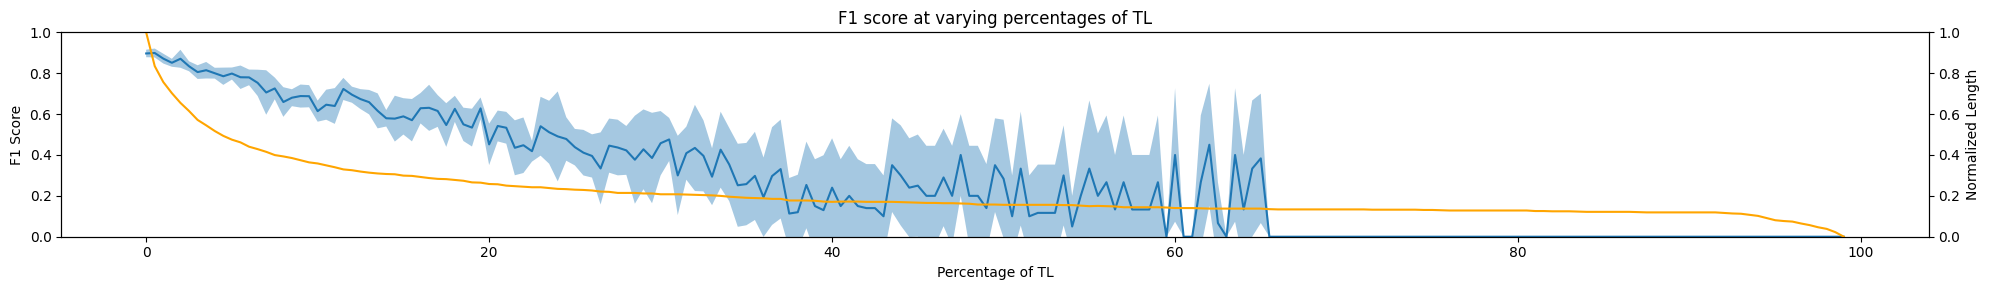

In [213]:


import numpy as np
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

lengths = pd.DataFrame(lengths)

plt.ylim((0, 1))
y = np.array(f1_scores_mean)
err = np.array(f1_scores_std)

plt.rcParams["figure.figsize"] = (10, 6)
ax1.plot(np.arange(0, 99.5, 0.5), y, label='F1 score')
ax1.set_title("F1 score at varying percentages of TL")
ax1.fill_between(np.arange(0, 99.5, 0.5), y - err, y + err, alpha=0.4)

# Normalize the 'length' data between 0 and 1
normalized_length = (lengths - lengths.min()) / (lengths.max() - lengths.min())

# Create a new axis on the right side of the graph
ax2 = ax1.twinx()
ax2.set_ylim(0, 1)
ax2.plot(np.arange(0, 99.5, 0.5), normalized_length, label='Normalized Length', color='orange')

# Set up the legend for both lines
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

# Set up the axis labels
ax1.set_xlabel('Percentage of TL')
ax1.set_ylabel('F1 Score')
ax2.set_ylabel('Normalized Length')

plt.tight_layout()
plt.savefig("f1_over_time.svg")

